# Plotting IROF

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
from typing import List, Tuple, Dict, Any, Union, Optional
import quantus
from pytorch_grad_cam import EigenCAM
from torch.nn import functional as F

In [8]:
import importlib
import sys
if 'my_irof' in sys.modules:
    importlib.reload(sys.modules['my_irof'])
    
from src.utils.data import get_data_loaders
from src.models.resnet import get_model
from my_irof import IROF


## Utility Functions: Model Loading and Device Setup

These helper functions load pre-trained models and configure the computational device (GPU/CPU/MPS). The `load_model()` function handles checkpoint loading from saved model files, while `set_device()` selects CUDA, Metal Performance Shaders (MPS), or CPU based on availability.

### Model Storage
Models are saved locally in the following structure:
```
CLXAI/
└── models/
    ├── ce_seed0_best_model.pt
    └── scl_seed0_best_model.pt
```

In [9]:
def load_model(architecture: str, num_classes: int, path: str, device, encoder_only: bool = True) -> nn.Module:
    """Load a model given its architecture and number of classes."""
    model = get_model(architecture=architecture, num_classes=num_classes, encoder_only=encoder_only).to(device)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    
    # Handle both checkpoint dictionaries and raw state dicts
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    model.load_state_dict(state_dict)
    return model.eval()

def set_device():
    """Set the computation device."""
    import torch
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')   
    else:
        device = torch.device('cpu')

    return device

In [10]:
architecture = "resnet18"
model_type = "scl"
encoder_only = True
num_classes = 10
seed = 0
device = set_device()
dataset = "cifar10"

## Model and Data Configuration
Load the pre-trained model and initialize data loaders for training and testing. Using ResNet18 architecture with SCL (Supervised Contrastive Learning) on CIFAR-10 dataset.

In [11]:
model = load_model(
        architecture=architecture,
        num_classes=num_classes,
        path=f"models/{model_type}_seed{seed}_best_model.pt",
        encoder_only=encoder_only,
        device=device
    )

train_loader, test_loader = get_data_loaders(
        dataset=dataset,
        data_dir='./data',
        batch_size=64,
        num_workers=4,
        augment=True
    )

## Visualization Functions
Define plotting utilities to visualize the computed distances and explanation scores. These functions handle both individual distance curves and aggregated statistics with error bands.

In [12]:
from itertools import chain

def plot_distance_curves(
        results: List[Tuple[Any, List[float]]], 
        title: str = "Distances to Centroid",
        y_label: str = "1/Distance to Centroid", 
        cam_type: str = "GradCAM",
        figsize: Tuple[int, int] = (10, 6),
        alpha: float = 0.7
    ) -> None:
        """
        Plot individual distance curves with improved styling and error handling.
        
        Args:
            results: List of tuples containing (metadata, distance_curve)
            title: Plot title
            y_label: Y-axis label
            cam_type: Camera type for filename
            figsize: Figure size
            alpha: Line transparency
        """
        plt.figure(figsize=figsize)
        
        curve_count = 0
        for _, preds in chain.from_iterable(results):
            if len(preds) > 0:  # Check for non-empty predictions
                plt.plot(preds, alpha=alpha)
                curve_count += 1
        
        if curve_count == 0:
            print("No valid curves found to plot")
            return
        
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel("Perturbation Step", fontsize=12)
        plt.ylabel(y_label, fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [13]:
def plot_avg_distance_curve(
        results: List[Tuple[Any, List[float]]],
        title: str = "Average 1/Distance to Centroid",
        y_label: str = "Average 1/Distance to Centroid",
        cam_type: str = "GradCAM",
        show_std: bool = True,
        figsize: Tuple[int, int] = (10, 6),
        color: str = 'blue'
    ) -> None:
        """
        Plot average distance curve with standard deviation.
        
        Args:
            results: List of tuples containing (metadata, distance_curve)
            title: Plot title
            y_label: Y-axis label
            cam_type: Camera type for filename
            show_std: Whether to show standard deviation
            figsize: Figure size
            color: Line color
        """
        try:
            
            
            if not results:
                print("No results provided for plotting")
                return
            
            # Extract and validate curves
            curves = []
            for _, curve in chain.from_iterable(results):
                if len(curve) > 0:
                    curves.append(np.asarray(curve, dtype=np.float32))
            
            if not curves:
                print("No valid curves found")
                return
            
            # Pad curves to same length with np.nan
            max_len = max(len(curve) for curve in curves)
            padded = np.full((len(curves), max_len), np.nan, dtype=np.float32)
            
            for i, curve in enumerate(curves):
                padded[i, :len(curve)] = curve
            
            # Compute statistics
            mean_curve = np.nanmean(padded, axis=0)
            
            plt.figure(figsize=figsize)
            steps = np.arange(len(mean_curve))
            plt.plot(steps, mean_curve, label="Mean", marker='o', color=color, markersize=4)
            
            if show_std:
                std_curve = np.nanstd(padded, axis=0)
                plt.fill_between(
                    steps, 
                    mean_curve - std_curve, 
                    mean_curve + std_curve,
                    alpha=0.3, 
                    label="Std Dev",
                    color=color
                )
            
            plt.title(title, fontsize=14, fontweight='bold')
            plt.xlabel('Perturbation Step', fontsize=12)
            plt.ylabel(y_label, fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=10)
            plt.tight_layout()
            
            
        except Exception as e:
            raise RuntimeError(f"Error plotting average distance curve: {e}")

## Explanation Generation Pipeline
Helper functions to prepare inputs, generate EigenCAM explanations, and integrate them with the model. The pipeline validates input dimensions and handles tensor-to-numpy conversions seamlessly.

In [14]:
def _prepare_inputs(
        inputs: Union[np.ndarray, torch.Tensor], 
        targets: Optional[Union[np.ndarray, torch.Tensor]] = None
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

        if isinstance(inputs, np.ndarray):
            x_batch = torch.from_numpy(inputs).float()
        else:
            x_batch = inputs.float()
        
        # Move to device
        x_batch = x_batch.to(device)
        
        # Prepare targets if provided
        y_batch = None
        if targets is not None:
            if isinstance(targets, np.ndarray):
                y_batch = torch.from_numpy(targets).float()
            else:
                y_batch = targets.float()
            y_batch = y_batch.to(device)
        
        # Validate input dimensions
        if len(x_batch.shape) != 4:
            raise ValueError(f"Expected 4D input (batch, channels, height, width), got {x_batch.shape}")
        
        
        return x_batch, y_batch

In [15]:
import warnings

def _get_target_layer(model, target_layer_idx: int) -> nn.Module:
        return model.layer4[-1].conv2
        
def _generate_eigencam(
        model: nn.Module,
        x_batch: torch.Tensor,
        target_layer_idx: int,
        eigen_smooth: bool = False
    ) -> np.ndarray:
        """Generate EigenCAM explanations"""
        target_layer = _get_target_layer(model, target_layer_idx)
        target_layers = [target_layer]
        cam = EigenCAM(model=model, target_layers=target_layers)
            
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grayscale_cams = cam(input_tensor=x_batch, eigen_smooth=eigen_smooth)
            
        return grayscale_cams
        
def generate_expl(model, inputs, targets, target_layer_idx, **kwargs):
    x_batch, y_batch = _prepare_inputs(inputs, targets)
    grayscale_cams = _generate_eigencam(
        model=model,
        x_batch=x_batch,
        target_layer_idx=target_layer_idx
    )
    return grayscale_cams

## IROF Score Computation
Main function to compute IROF scores. This iterates through data batches, generates explanations, and evaluates explanation fidelity using distance-based metrics (or confidence when ```distance_based = False```) on learned class centroids.

In [16]:
def expl_scores(
    model,
    data_loader,
    expl_type: str = "irof",
    method: str = "EigenCAM",
    perturb_baseline: str = "mean",
    return_scores: bool = True,
    distance_based: bool = False,
    softmax: bool = True,
    device: str = 'cpu',
    nr_samples: int = 10,
    max_batches: Optional[int] = None,
    centroids: Optional[Dict] = None
) -> List[Any]:
    """
    Calculate explanation scores with improved error handling and flexibility.
    
    Args:
        model: The model to analyze
        data_loader: DataLoader with input data
        expl_type: Type of explanation metric ("irof", "ris", "rrs")
        method: Explanation method (e.g., "GradCAM, EigenCAM")
        perturb_baseline: Baseline for perturbation
        return_scores: Whether to return scores
        distance_based: Whether to use distance-based metrics
        softmax: Whether to apply softmax
        device: Device to run on
        nr_samples: Number of samples for stability metrics
        max_batches: Maximum number of batches to process (None for all)
        centroids: Dictionary of class centroids for distance-based metrics
        
    Returns:
        List of computed scores
    """
    
    scores = []
    total_batches = min(len(data_loader), max_batches) if max_batches else len(data_loader)
   
    for i, datapoints in tqdm(enumerate(data_loader), total=total_batches, desc=f"Processing {expl_type}"):
        if max_batches and i >= max_batches:
            break

        x_batch, _ = datapoints
        
        # Validate input shapes
        if len(x_batch.shape) != 4:  # Assuming image data (N, C, H, W)
            print(f"Warning: Unexpected input shape: {x_batch.shape}")
        
        with torch.no_grad():
            y_batch = model(x_batch.to(device))
            y_batch = y_batch.argmax(dim=1)
        
        x_batch_np = x_batch.cpu().numpy()
        y_batch_np = y_batch.cpu().numpy().astype(int)
        
        # Initialize metric based on type
        if expl_type == "irof":
            metric = IROF(
                segmentation_method="slic",
                perturb_baseline=perturb_baseline,
                return_aggregate=False,
                return_scores=return_scores,
                distance_based=distance_based,
            )
            
            # Set centroids if using distance-based evaluation
            if distance_based:
                if centroids is None:
                    raise ValueError("need to evaluate the centroids before")
                else:
                   metric.centroids = centroids
        else:
            raise ValueError(f"Unsupported explanation type: {expl_type}")
    
        
        # this can be expanded to support different methods
        explain_func_kwargs = {"target_layer_idx": -1}
        
        # Call metric without extra kwargs
        method_scores = metric(
            model=model.eval(),
            x_batch=x_batch_np,
            y_batch=y_batch_np,
            explain_func=generate_expl,
            explain_func_kwargs=explain_func_kwargs,
            device=device,
            softmax=softmax
        )
        
        scores.append(method_scores)
        

    print(f"Processed {len(scores)} batches successfully")
    return scores

## Computing Class Centroids
Calculate the centroid (mean embedding) for each class in the training data. These centroids will be used as reference points for distance-based explanation evaluation in the IROF metric.

In [17]:
def compute_centroids(model, data_loader, n_classes, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for datapoints in tqdm(data_loader, desc="Computing Embeddings"):
            x_batch, y_batch = datapoints
            x_batch = x_batch.to(device)
            embedding_batch = model(x_batch)
            embedding_batch = embedding_batch.view(embedding_batch.size(0), -1)
            embeddings.append(embedding_batch.cpu())
            labels.append(y_batch)
    
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    
    centroids = {}
    for class_label in torch.unique(labels):
        class_embeddings = embeddings[labels == class_label]
        centroid = class_embeddings.mean(dim=0)
        centroids[class_label.item()] = centroid
    
    return centroids

In [18]:
# Use the computed centroids from the previous cell
centroids = compute_centroids(model, train_loader, num_classes, device)

Computing Embeddings: 100%|██████████| 781/781 [01:07<00:00, 11.50it/s]


## Evaluation and Results
Run IROF evaluation on the test set with distance-based metrics using the computed centroids. Generate visualizations showing individual distance curves and aggregated statistics.

NB: THE PIPELINE ONLY WORKS WHEN THE MODEL IS AN ENCODER, I ONLY TESTED ON AN SLC MODEL, BUT FOR CE MODELS MAKE SURE TO DISCARD OR SET TO IDENTITY ANYTHING THAT COMES AFTER THE EMBEDDING SPACE

In [19]:
import traceback

try:
    distance_score = expl_scores(
        model=model, 
        data_loader=test_loader, 
        expl_type="irof", 
        method="EigenCAM", 
        distance_based=True, 
        softmax=False, 
        device=device, 
        max_batches=1, 
        centroids=centroids
    )
except Exception as e:
    print("Error type:", type(e).__name__)
    print("Error message:", str(e))
    print("\nFull traceback:")
    traceback.print_exc()

Processing irof: 100%|██████████| 1/1 [00:39<00:00, 39.35s/it]


Processed 1 batches successfully


finished computing IROF


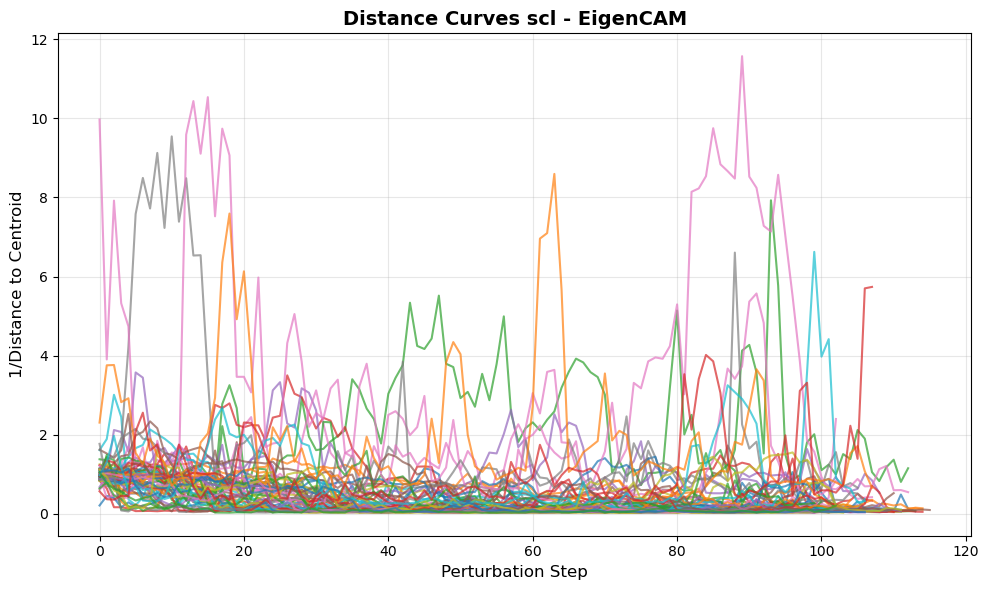

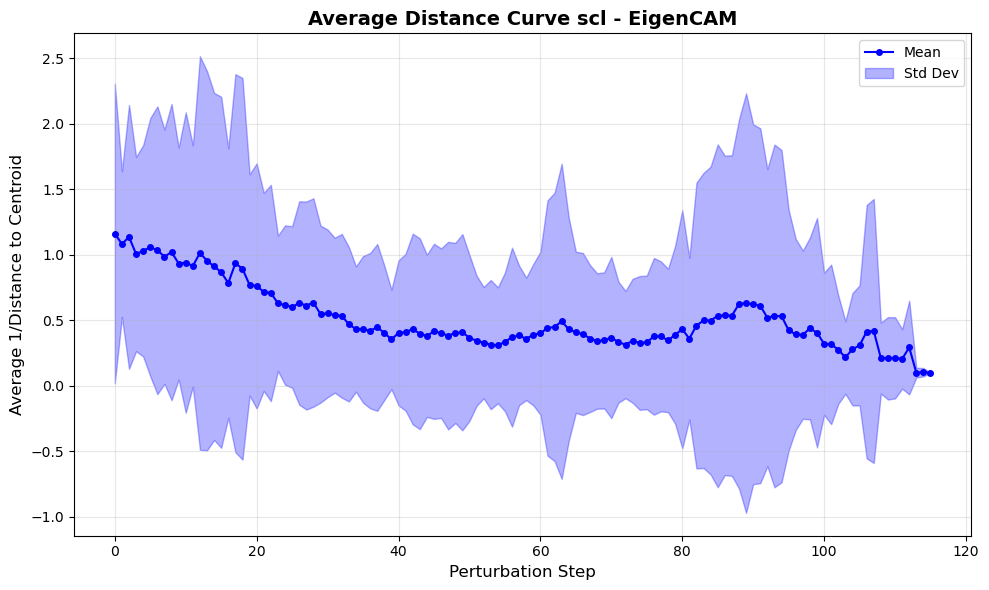

In [20]:
print("finished computing IROF")
plot_distance_curves(distance_score, title=f"Distance Curves {model_type} - EigenCAM", cam_type="EigenCAM")
plot_avg_distance_curve(distance_score, title=f"Average Distance Curve {model_type} - EigenCAM", cam_type="EigenCAM")

Code to implement and visualize confidence based scores.

python(31014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing irof: 100%|██████████| 1/1 [00:47<00:00, 47.47s/it]


Processed 1 batches successfully
finished computing IROF


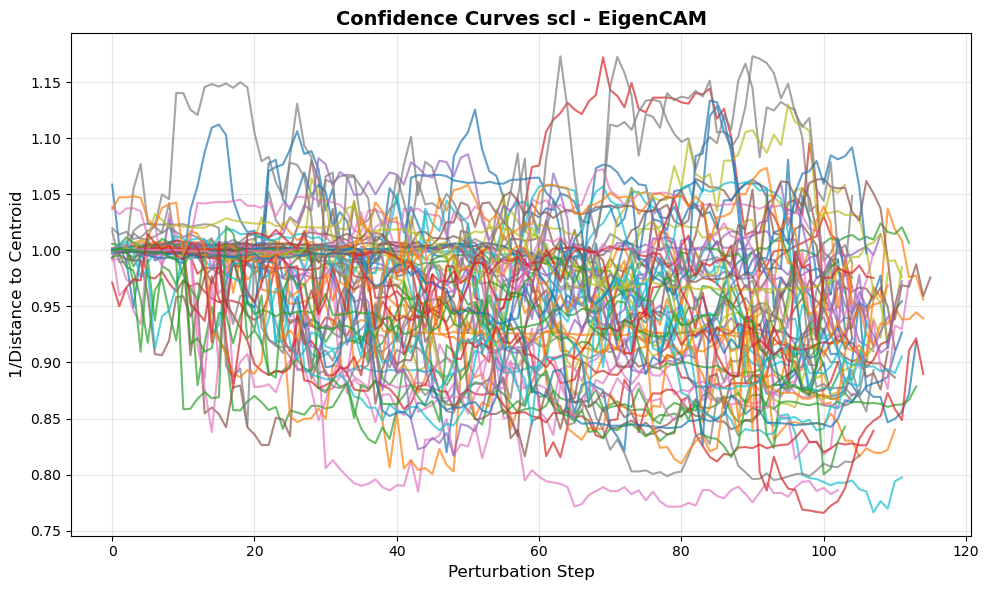

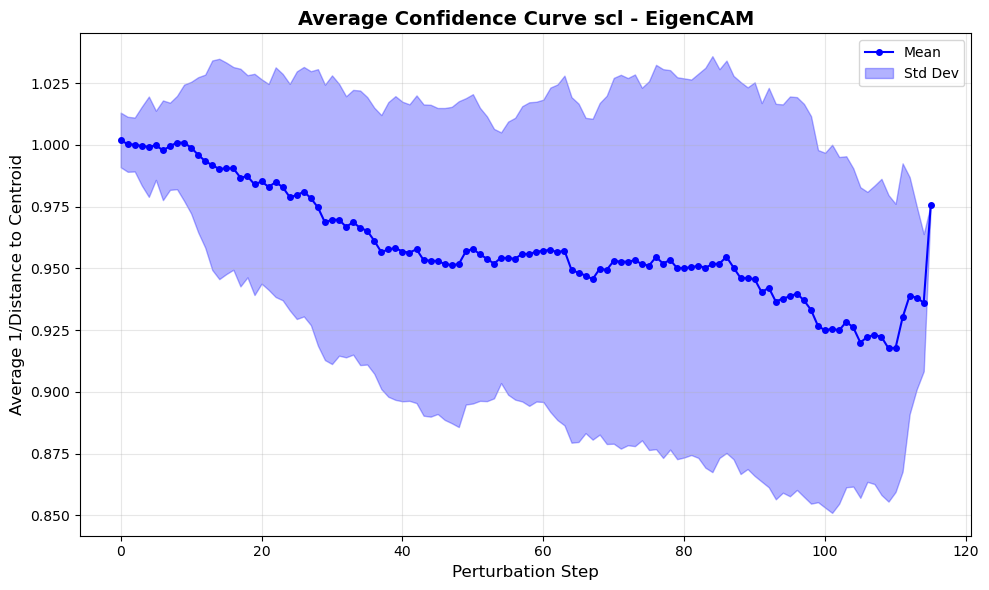

In [21]:
import traceback

try:
    distance_score = expl_scores(
        model=model, 
        data_loader=test_loader, 
        expl_type="irof", 
        method="EigenCAM", 
        distance_based=False, 
        softmax=True, 
        device=device, 
        max_batches=1
    )
except Exception as e:
    print("Error type:", type(e).__name__)
    print("Error message:", str(e))
    print("\nFull traceback:")
    traceback.print_exc()

print("finished computing IROF")

plot_distance_curves(distance_score, title=f"Confidence Curves {model_type} - EigenCAM", cam_type="EigenCAM")
plot_avg_distance_curve(distance_score, title=f"Average Confidence Curve {model_type} - EigenCAM", cam_type="EigenCAM")